In [1]:
using Distributions, Random, Plots, DataFrames, Optim
using LinearAlgebra, StatsFuns, QuadGK, HypothesisTests
using LaTeXTabulars, LaTeXStrings

In [2]:
### Simulated auction set-up

# Auction parameters
Random.seed!(6789998212);
I = 10;   # Number of bidders
N = 1000; # Number of auctions

# Draw valuations and calculate bids
μ = 0
σ = 1
v = randn(N,I) .* σ .+ μ; # Draw valuations from N(μ,σ)
b = v;                    # Optimal bid strategy for SPA

In [3]:
### Second-price auction

# Store winning bid and price paid
b_sort = sort(b, dims = 2);
spa = [b_sort[:,I] b_sort[:,I-1]];

# Simulated mean highest and second-highest bid 
println("Simulated highest and second-highest bid: ", mean(spa, dims = 1))

# Analytic formula using quadrature
f = Normal(μ,σ)
b_1(x) = I * x * pdf(f,x) * cdf(f,x)^(I-1)
b_2(x) = I * (I-1) * x * pdf(f,x) * cdf(f,x)^(I-2) * (1-cdf(f,x))

Eb_1 = quadgk(x -> b_1(x), -Inf, +Inf)[1]
Eb_2 = quadgk(x -> b_2(x), -Inf, +Inf)[1]

println("Theoretical highest and second-highest bid: [$Eb_1, $Eb_2]")

Simulated highest and second-highest bid: [1.5073422199326407 0.9759201851521684]
Theoretical highest and second-highest bid: [1.5387527308351685, 1.0013570445747912]


In [4]:
### eBay auction
### Returns DataFrame with [Number of participants, (up to) three-highest observed bids, bidding times of top-2 bidders]
### as well as Vector of all observed bids 

function ebay(v)
    ## Run simulated auction
    
    r  = -100000;        # Reserve (starting) price
    h₀ = ones(N,I) .* r; # What each bidder observes when they arrive
    c  = ones(N,I) .* r; # Highest submitted cutoff  
    h₁ = ones(N,I) .* r; # Standing price after bidder makes bid decision

    bₑ = [];             # Store of submitted bids across auctions
    np = zeros(Int8, N); # Number of participants
    for n = 1:N
        b_temp = [];  # Store of bids in each auction
        for i = 1:I
            if i > 1
                h₀[n,i] = h₁[n,i-1]  # Update initial price
                if v[n,i] > h₀[n,i]  # Bidder enters if valuation above observed price
                    np[n]  += 1
                    c[n,i]  = max(c[n,i-1],v[n,i]) # Current highest cutoff updates, bidders bid their valuation
                    h₁[n,i] = min(c[n,i-1],v[n,i]) # Standing price updates
                    push!(b_temp, v[n,i])          # Store bid
                else                 # Bidder stays out
                    c[n,i]  = c[n,i-1]
                    h₁[n,i] = h₀[n,i]
                end
            else
                if v[n,1] > h₀[n,1]
                    np[n]  += 1
                    c[n,1]  = v[n,1]
                    push!(b_temp, v[n,1])
                end
            end
        end
        push!(bₑ, b_temp)
    end
    
    ## Construct eBay dataset for estimation
    
    # Reverse sort submitted bids
    sorted_bids = sort.(bₑ, rev=true);

    # Observed bids (drop highest bid)
    obs_bids     = deleteat!.(deepcopy(sorted_bids),1);

    # Create dataframe
    ebay_df = DataFrame(Auction   = 1:N, 
                        N_bidders = np, 
                        High_bid  = getindex.(sorted_bids,1),
                        Obs_bid_1 = getindex.(obs_bids,1),
                        Obs_bid_2 = fill(NaN, N),
                        Obs_bid_3 = fill(NaN, N));

    # Add in 2nd and 3rd highest bids, when observed
    ebay_df[ebay_df.N_bidders .> 2, :Obs_bid_2] = getindex.(obs_bids[length.(obs_bids) .> 1],2);
    ebay_df[ebay_df.N_bidders .> 3, :Obs_bid_3] = getindex.(obs_bids[length.(obs_bids) .> 2],3);

    # Add in bidding times of top-2 bidders
    # Know top-2 always participate: sort valuations and return index (sortperm) of highest and second-highest valuation
    ebay_df[!, :Bid_time_1] .= getindex.(sortperm.(collect(eachrow(v))),I);
    ebay_df[!, :Bid_time_2] .= getindex.(sortperm.(collect(eachrow(v))),I-1);

    return ebay_df, obs_bids
end

ebay (generic function with 1 method)

Row,Auction,N_bidders,High_bid,Obs_bid_1,Obs_bid_2,Obs_bid_3,Bid_time_1,Bid_time_2
,Int64,Int8,Float64,Float64,Float64,Float64,Int64,Int64
1,1,6,1.60121,1.54567,1.27403,1.04317,9,6
2,2,4,1.87595,0.925503,0.607327,0.226812,2,9
3,3,3,1.28146,0.450192,-0.901042,NaN,1,3
4,4,5,1.05841,0.969487,0.796078,-0.140402,9,2
5,5,7,1.51937,0.55059,0.50857,0.362004,8,5
6,6,3,2.28323,0.336793,-0.216525,NaN,2,7
7,7,7,1.65179,0.822833,0.305449,-0.617767,8,10
8,8,3,1.80459,1.45557,0.932617,NaN,3,2
9,9,7,0.963123,0.85632,0.687115,0.400529,7,9


Simulated highest and second-highest bid: [1.5073422199326407 0.9759201851521684]


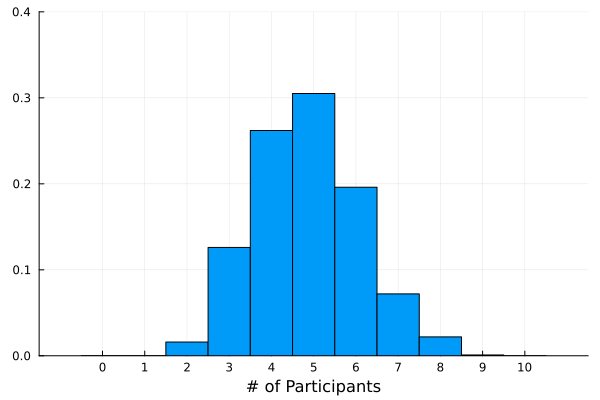

Mean (across auctions) of mean (within auction) observed bid: 0.2509695497580325
Variance (across auctions) of mean (within auction) observed bid: 0.20407093739101914


One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.25097
    95% confidence interval: (0.2229, 0.279)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-59

Details:
    number of observations:   1000
    t-statistic:              17.568328838901202
    degrees of freedom:       999
    empirical standard error: 0.01428533994663827


In [5]:
### eBay auction results

# Run one auction
ebay_df, obs_bids = ebay(v)
display(ebay_df)

# Simulated eBay auction mean highest and second-highest bid, mirrors SPA result
println("Simulated highest and second-highest bid: ", mean(Array(ebay_df[!,[:High_bid, :Obs_bid_1]]), dims = 1))

# Histogram of participants in each auction
display(histogram(ebay_df[!,:N_bidders],
            bins = 0:1:I+1,
            normalize = true,
            xticks = (0.5:1:I+0.5, 0:1:I), 
            xlimits = (-1,I+2),
            ylimits = (0,0.4),
            legend = false,
            xlabel = "# of Participants"));
savefig("output/ps3_q2_ebay_nbidders.pdf")
            
# Mean and variance of submitted bids, which selects on arrival time and standing price
println("Mean (across auctions) of mean (within auction) observed bid: ", mean(mean.(obs_bids)))
println("Variance (across auctions) of mean (within auction) observed bid: ",var(mean.(obs_bids)))

# Test null that mean bid is 0, reject
ttest = OneSampleTTest(mean.(obs_bids), 0)
display(ttest)

test_n = string(ttest.n)
test_xbar = round(ttest.xbar, digits = 3)
test_sd = round(ttest.stderr * sqrt(ttest.n), digits = 3)
test_pv = round(pvalue(ttest, tail = :both), digits = 3)

latex_tabular("output/ps3_q2_ttest.tex",
              Tabular("cccc"),
              [["Obs" L"\bar{x}" "sd" "pval"],
               Rule(:mid),
               [test_n test_xbar test_sd test_pv],
               Rule(:bottom)]);

In [6]:
### Song (2004) estimate bid distribution function
### Return (negative) log-likelihood using vector of k1 and k2 highest bids from N auctions, k1 < k2 (e.g., 2nd and 3rd)
### Estimated parameters of (assumed) normal bid distribution are θ = (m, s)

function likelihood(y, x, k1, k2, θ)
    # bid distribution (assumed normal)
    m = θ[1]
    s = sqrt(θ[2]^2)

    if isempty(x)
        c = -10000
    else
        c = minimum(x)
    end
    v = truncated(Normal(m,s); lower=c)
    
    # calculate log-likelihood
    l = (1/N) * sum(log.(binomial(k2 - 1, k2 - k1)) .+ (k2 - k1 - 1) .* log.(cdf.(v,y) - cdf.(v,x)) + (k1 - 1) .* log.(1 .- cdf.(v,y)) + log.(pdf.(v,y)) - (k2 - 1) .* log.(1 .- cdf(v,x)))
    
    return -l
end

likelihood (generic function with 1 method)

In [7]:
### Estimation

# S simulations of N auctions with I bidders
I = 10
N = 5000
S = 50

# Store results for each set of order statics pairs (23 = 1st-2nd observed)
res_23 = []
res_24 = []
res_24a = []
res_34 = []
windows = [I-1, I-2, I-3, I-5, I-7, 0] # Set window sizes, (I-1 = last period only, I-2 = last two periods)
for s = 1:S
    # Simulate new set of auctions
    v_sim = randn(N,I) .* σ .+ μ; 
    ebay_df, obs_bids = ebay(v_sim)
    
    # First-Second (require at least one top-2 bids arrive after window)
    res_temp = []
    k1 = 2 # First
    k2 = 3 # Second
    for window in windows
        y = Vector(ebay_df[ebay_df.N_bidders .>= k2 .&& (ebay_df.Bid_time_1 .> window .|| ebay_df.Bid_time_2 .> window), :Obs_bid_1])
        x = Vector(ebay_df[ebay_df.N_bidders .>= k2 .&& (ebay_df.Bid_time_1 .> window .|| ebay_df.Bid_time_2 .> window), :Obs_bid_2])

        o = optimize(θ -> likelihood(y,x,k1,k2,θ), [0.0, 1.0], NelderMead())

        push!(res_temp,[length(y) o.minimizer[1] sqrt(o.minimizer[2]^2)])
    end  
    push!(res_23,reduce(vcat,res_temp))
    
    # First-Third (require at least one top-2 bids arrive after window)
    res_temp = []
    k1 = 2 # First
    k2 = 4 # Third
    for window in windows
        y = Vector(ebay_df[ebay_df.N_bidders .>= k2 .&& (ebay_df.Bid_time_1 .> window .|| ebay_df.Bid_time_2 .> window), :Obs_bid_1])
        x = Vector(ebay_df[ebay_df.N_bidders .>= k2 .&& (ebay_df.Bid_time_1 .> window .|| ebay_df.Bid_time_2 .> window), :Obs_bid_3])

        o = optimize(θ -> likelihood(y,x,k1,k2,θ), [1.0, 1.0], NelderMead())

        push!(res_temp,[length(y) o.minimizer[1] sqrt(o.minimizer[2]^2)])
    end
    push!(res_24,reduce(vcat,res_temp))

    # First-Third (require both top-2 bids arrive after window)
    res_temp = []
    k1 = 2 # First
    k2 = 4 # Third
    for window in windows
        y = Vector(ebay_df[ebay_df.N_bidders .>= k2 .&& (ebay_df.Bid_time_1 .> window .&& ebay_df.Bid_time_2 .> window), :Obs_bid_1])
        x = Vector(ebay_df[ebay_df.N_bidders .>= k2 .&& (ebay_df.Bid_time_1 .> window .&& ebay_df.Bid_time_2 .> window), :Obs_bid_3])

        o = optimize(θ -> likelihood(y,x,k1,k2,θ), [1.0, 1.0], NelderMead())

        push!(res_temp,[length(y) o.minimizer[1] sqrt(o.minimizer[2]^2)])
    end
    push!(res_24a,reduce(vcat,res_temp))
    
    # Second-Third (require both top-2 bids arrive after window)
    res_temp = []
    k1 = 3 # Second
    k2 = 4 # Third
    for window in windows
        y = Vector(ebay_df[ebay_df.N_bidders .>= k2 .&& (ebay_df.Bid_time_1 .> window .&& ebay_df.Bid_time_2 .> window), :Obs_bid_2])
        x = Vector(ebay_df[ebay_df.N_bidders .>= k2 .&& (ebay_df.Bid_time_1 .> window .&& ebay_df.Bid_time_2 .> window), :Obs_bid_3])

        o = optimize(θ -> likelihood(y,x,k1,k2,θ), [1.0, 1.0], NelderMead())

        push!(res_temp,[length(y) o.minimizer[1] sqrt(o.minimizer[2]^2)])
    end
    push!(res_34,reduce(vcat,res_temp)) 
end

In [8]:
### Output results

formatted_res = hcat([L"\tau = 1", L"\tau = 2", L"\tau = 3", L"\tau = 5", L"\tau = 7", L"\tau = none"], string.(Int.(floor.(mean(res_23)[:,1]))), round.(mean(res_23)[:,2:3],digits = 3), string.(Int.(floor.(mean(res_24)[:,1]))), round.(mean(res_24)[:,2:3],digits = 3), string.(Int.(floor.(mean(res_24a)[:,1]))), round.(mean(res_24a)[:,2:3],digits = 3), string.(Int.(floor.(mean(res_34)[:,1]))), round.(mean(res_34)[:,2:3],digits = 3))

latex_tabular("output/ps3_q2_estimation.tex",
              Tabular("ccccccccccccc"),
              [["" MultiColumn(3, :c, "1st-2nd") MultiColumn(3, :c, "1st-3rd") MultiColumn(3, :c, "1st-3rd*") MultiColumn(3, :c, "2nd-3rd*")],
               CMidRule("l",2,4), CMidRule("l",5,7), CMidRule("l",8,10), CMidRule("l",11,13),
               ["Window", L"\bar{\text{Obs}}", L"\hat{\mu}", L"\hat{\sigma}", L"\bar{\text{Obs}}", L"\hat{\mu}", L"\hat{\sigma}", L"\bar{\text{Obs}}", L"\hat{\mu}", L"\hat{\sigma}", L"\bar{\text{Obs}}", L"\hat{\mu}", L"\hat{\sigma}"],
               Rule(:mid),
               formatted_res,
               Rule(:bottom)]);